In [1]:
cd("/home/jzh/Dropbox/Research/Data-driven_estimation_inverse_optimization/Experiments/InverseVIsTraffic")

In [2]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    trueflow::Float64
    obsflow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0., 0.)

Arc (constructor with 3 methods)

In [3]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  
#VG think about faster way to do this

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 
    #separate for consts

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.obsflow, arc)

bpacost (generic function with 3 methods)

In [4]:
function setUpFitting(deg::Int, c, odpairs, nodes)
	m = Model(solver=GurobiSolver(OutputFlag=false))
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	##VG Probably want to go back and redo this with an intercept term
	#build the graham matrix
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	assert(rank(K) == deg+1)
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr() )
	@addConstraint(m, reg_term >= reg_term_)

	return m, coeffs, reg_term
end

setUpFitting (generic function with 1 method)

In [5]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [6]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.obsflow * a.freeflowtime * polyEval(coeffs, a.obsflow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [7]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.obsflow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [8]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.obsflow * polyEval(coeffs, a.obsflow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [9]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.obsflow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [10]:
# Uses a Frank-Wolfe algorithm to solve bpa cost for the given network.
# cf. [Patriksson] Page 96-97
# construct the underlying graph
# Fix an ordering of the arcs... should just be pointers
function frank_wolfe(g, vArcs, demand_data, idx; TOL=1e-4, MAX_ITERS=100)
    #use the observed flows as the starting point
    flows =[a.obsflow::Float64 for a in vArcs]
    costs = [bpacost(a) for a in vArcs]
    trace = Float64[]
    for iter = 1:MAX_ITERS
        flow_dict = Dict{(Int, Int), Float64}()
        for odpair = keys(demand_data)
            #solve the shortest path problems, and update the total flow
            r = dijkstra_shortest_paths(g, costs, odpair[1] )
            currNode = odpair[2];
            while currNode != odpair[1]
                parent = r.parents[currNode]
                if ! haskey(flow_dict, (parent, currNode) )
                    flow_dict[(parent, currNode)] = demand_data[odpair][idx]  
                else
                    flow_dict[(parent, currNode)] += demand_data[odpair][idx]  
                end
                currNode = parent
            end
        end

        d = [get(flow_dict, (a.initNode, a.termNode), 0.)::Float64 for a in vArcs]

        #In the first iteration, just pull out the flows
        if iter == 1
        	flows = d
        	costs = [bpacost(flows[ix], a) for (ix, a) in enumerate(vArcs)]
        	continue
        end
        assert( dot(costs, d) <= dot(flows, costs) )
        d -= flows 
        derivFun(alpha) = sum([bpacost(flows[ix] + alpha*d[ix], a)*d[ix] for (ix, a) in enumerate(vArcs)])
        if derivFun(0) >=0 
            alpha = 0
        elseif derivFun(1) <= 0
            alpha = 1
        else
            alpha = fzero(derivFun, 0, 1)
        end
        converge_dist = alpha * norm(d) / norm(flows)
        flows += alpha * d
        push!(trace, converge_dist)
        if (iter > 1) & (converge_dist <= TOL)
            break
        else
            costs = [bpacost(flows[ix], a) for (ix, a) in enumerate(vArcs)]
        end
    end

    return trace[length(trace)], flows
end

frank_wolfe (generic function with 1 method)

In [11]:
############
#Read in the demand file
file = open("./data_original/SiouxFalls_trips.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand 
            end
        end
    end
end                
close(file)

In [12]:
############
#read in the arc files
arcs = Dict{(Int, Int), Arc}()
file = open("./data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), float(vals[3]), float(vals[5]))
end
close(file)

In [13]:
###########
#read in the initial flows
file = open("./data_original/SiouxFallsFlow.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].trueflow = float(vals[3])
end
close(file)

In [14]:
#include("genSimData.jl")

## File that runs the entire cross-val analysis and 
## dumps it for the traffic stuff


#include("fitTraffic.jl")
#using PyPlot


##########
#Generate the simulated data
##########
numData = 1; sigma = .0
flow_data = Array(Float64, length(arcs), numData)
demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    arc.obsflow = arc.trueflow
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end

#srand(8675309)
for iRun = 1:numData
    #perturb the demand_data
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair] * (1 + sigma * rand()), ]
        else
            push!(demand_data[odpair], demands[odpair] * (1  + sigma * rand()))
        end
    end
    #solve using FW and record
    conv_tol, flow_data[:, iRun] = frank_wolfe(g, vArcs, demand_data, iRun)
    println(conv_tol)
end

#Randomzie the flow data a little bit too
for i = 1:size(flow_data, 1)
    for j = 1:size(flow_data, 2)
        flow_data[i, j] *= (1 + sigma * rand() )
    end
end

0.0020838400284947925


In [15]:
using DataFrames, Resampling


##########
#Fitting Funcs
##########
#build a little train function that just takes indices
function train(indices, lam::Float64, deg::Int, c::Float64, 
                demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c, [k for k=keys(demand_data)], 1:numNodes)
    
    for a in values(arcs)
        a.obsflow = a.trueflow
    end
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  
    #uses the original obs flows

    avgCost = mean( [bpacost(a.obsflow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.obsflow / a.capacity for a in values(arcs)], avgCost)

    # normalize(m, coeffs, 1., bpacost(1., 1., 1.))


    resids = Variable[]
    for i = indices
        # copy the flow data over to the arcs, 
        # demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.obsflow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [16]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 576 entries:
  (23,8)  => [300.0]
  (8,23)  => [300.0]
  (6,9)   => [400.0]
  (18,3)  => [0.0]
  (21,13) => [600.0]
  (22,16) => [1200.0]
  (15,17) => [1500.0]
  (22,14) => [1200.0]
  (13,9)  => [600.0]
  (23,10) => [1800.0]
  (24,22) => [1100.0]
  (8,9)   => [800.0]
  (9,1)   => [500.0]
  (17,14) => [700.0]
  (16,6)  => [900.0]
  (16,12) => [700.0]
  (16,13) => [600.0]
  (22,2)  => [100.0]
  (24,3)  => [0.0]
  (7,16)  => [1400.0]
  (1,12)  => [200.0]
  (4,5)   => [500.0]
  (11,8)  => [800.0]
  (18,21) => [100.0]
  (19,4)  => [200.0]
  ⋮       => ⋮

In [18]:
#include("trafficCval.jl")

arcs3 = arcs
arcs4 = arcs
arcs5 = arcs
arcs6 = arcs
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

# deg = 3
deg = 3
c = 3.41
lam = 1.

fcoeffs3 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs3)
coeffs_dict[(deg, c, lam)] = fcoeffs3

# deg = 4
deg = 4
c = 3.41
lam = 1.

fcoeffs4 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs4)
coeffs_dict[(deg, c, lam)] = fcoeffs4

# deg = 5
deg = 5
c = 2.6
lam = .1

fcoeffs5 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs5)
coeffs_dict[(deg, c, lam)] = fcoeffs5

# deg = 6
deg = 6
c = 2.6
lam = 1e-3

fcoeffs6 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs6)
coeffs_dict[(deg, c, lam)] = fcoeffs6

0.10617712562416262
0.011949011106671514
0.0111313373109262
0.010985410729513404


7-element Array{Float64,1}:
  0.986231 
  0.210829 
 -0.552565 
  0.685618 
 -0.344378 
  0.192347 
 -0.0298921

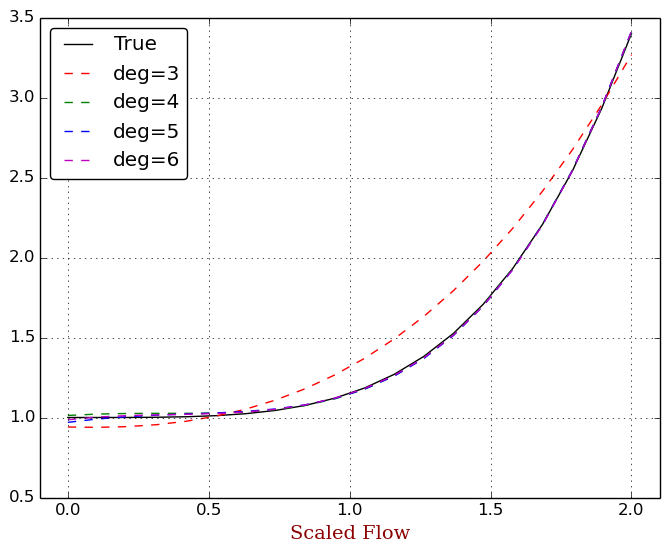

In [52]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]
fcoeffs3 = coeffs_dict[(3, 3.41, 1.)]
fcoeffs4 = coeffs_dict[(4, 3.41, 1.)]
fcoeffs5 = coeffs_dict[(5, 2.6, .1)]
fcoeffs6 = coeffs_dict[(6, 2.6, 1e-3)]

xs = linspace(0, 2, 20)
ys_true = map(x->polyEval(true_coeffs, x), xs)
ys3 = map(x->polyEval(fcoeffs3, x), xs)
ys4 = map(x->polyEval(fcoeffs4, x), xs)
ys5 = map(x->polyEval(fcoeffs5, x), xs)
ys6 = map(x->polyEval(fcoeffs6, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys_true, "k", label="True")
plot(xs, ys3, "--r", label="deg=3")
plot(xs, ys4, "--g", label="deg=4")
plot(xs, ys5, "--b", label="deg=5")
plot(xs, ys6, "--m", label="deg=6")
legend(loc="upper left",fancybox="true") 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.1);
ylim(0.5, 3.5);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("fitting.pdf")